## Word Segmentation

## Importing

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Reading and resizing

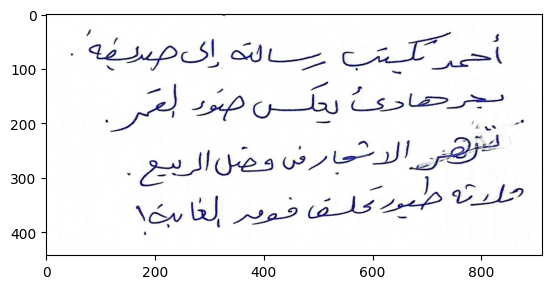

In [44]:
img = cv2.imread('/kaggle/input/segmentationtest/t1.PNG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, c = img.shape

if w > 1000:
    
    new_w = 1000
    ar = w/h
    new_h = int(new_w/ar)
    
    img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
plt.imshow(img);

## Preprocessing

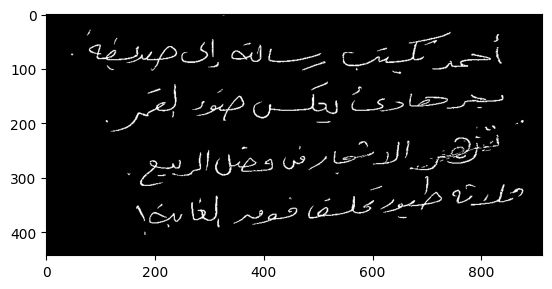

In [45]:
def thresholding(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,80,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(img);

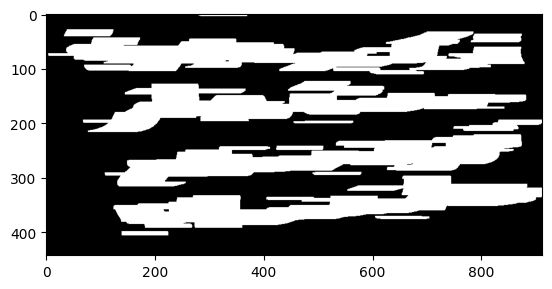

In [46]:
#dilation
kernel = np.ones((3,85), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated, cmap='gray');

In [47]:
(contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)

## Line segmentation

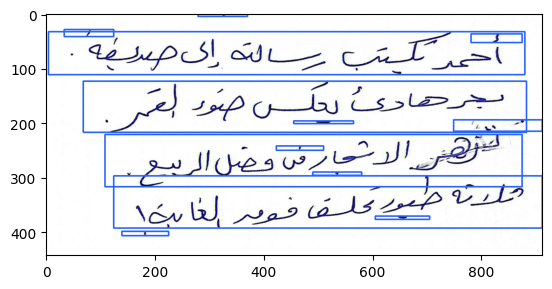

In [48]:
img2 = img.copy()

for ctr in sorted_contours_lines:
    
    x,y,w,h = cv2.boundingRect(ctr)
    cv2.rectangle(img2, (x,y), (x+w, y+h), (40, 100, 250), 2)
    
plt.imshow(img2);

## Text segmentation

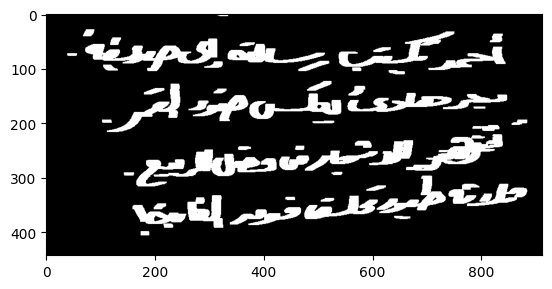

In [49]:
#dilation
kernel = np.ones((3,15), np.uint8)
dilated2 = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated2, cmap='gray');

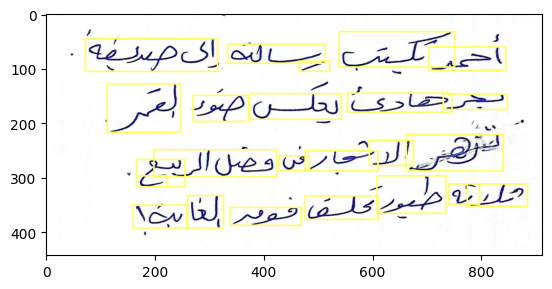

In [50]:
img3 = img.copy()
words_list = []

for line in sorted_contours_lines:
    
    # roi of each line
    x, y, w, h = cv2.boundingRect(line)
    roi_line = dilated2[y:y+h, x:x+w]
    
    # draw contours on each word
    (cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contour_words = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])
    
    for word in sorted_contour_words:
        
        if cv2.contourArea(word) < 400:
            continue
        
        x2, y2, w2, h2 = cv2.boundingRect(word)
        words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
        cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (255,255,100),2)
        
plt.imshow(img3);

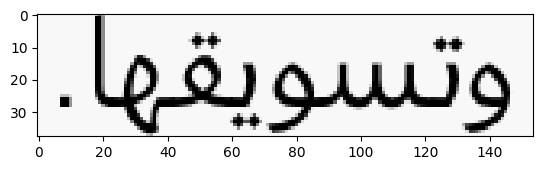

In [40]:
ninth_word = words_list[2]
roi_9 = img[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]
plt.imshow(roi_9);

---

## [Subscribe !](https://www.youtube.com/computervisionpro)

---

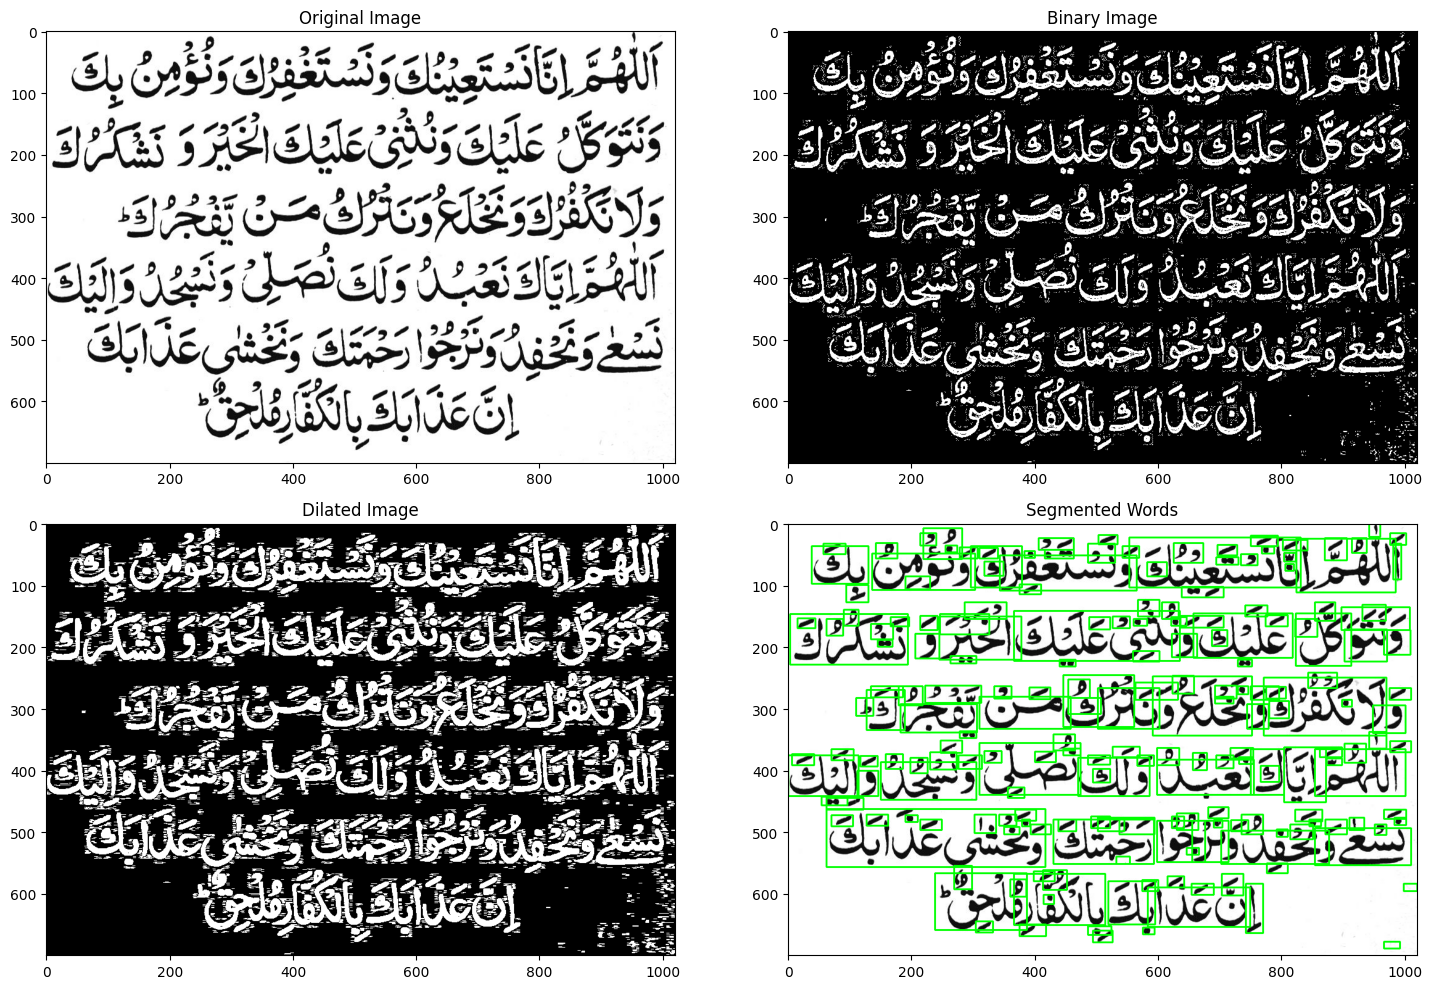

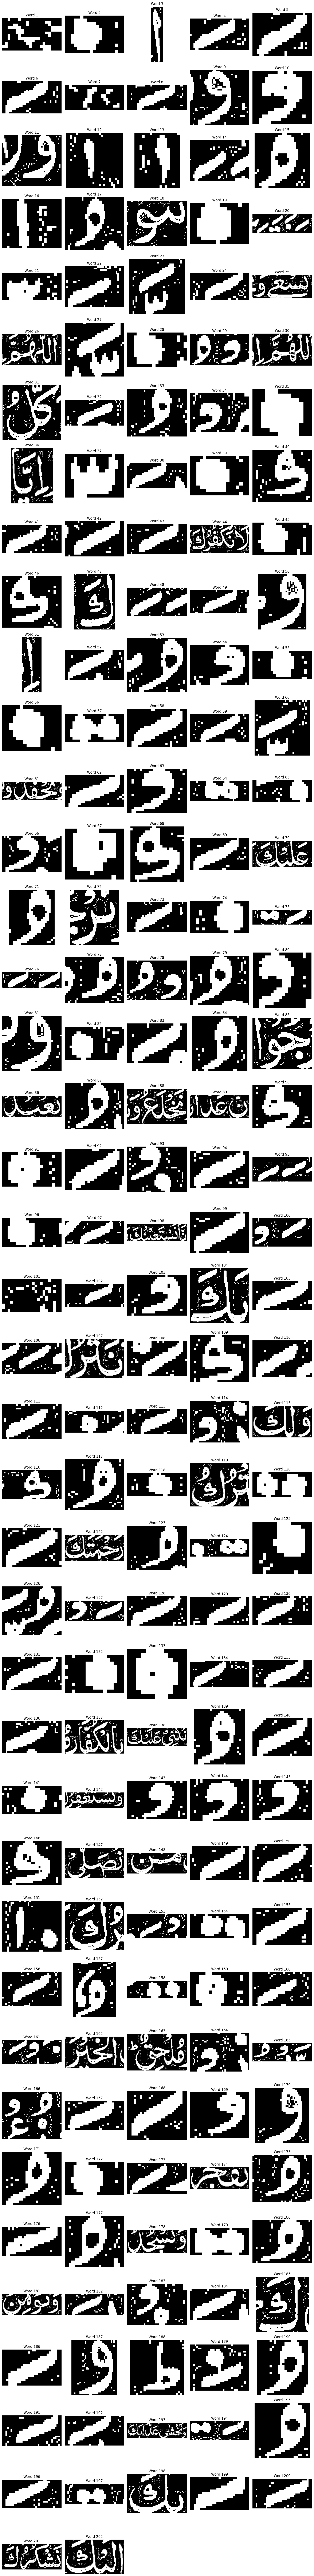

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pyarabic.araby as araby
from PIL import Image, ImageDraw, ImageFont
import pytesseract

def segment_arabic_text_advanced(image_path):
    # Read the image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY_INV, 11, 2)
    
    # Noise removal
    kernel = np.ones((1, 1), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Dilation to connect components within words
    dilation_kernel = np.ones((1, 5), np.uint8)  # Horizontal kernel to connect characters
    dilated = cv2.dilate(binary, dilation_kernel, iterations=1)
    
    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours from right to left (for Arabic)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0], reverse=True)
    
    # Extract word regions
    word_images = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter out very small contours (noise)
        if w > 10 and h > 10:
            word_img = binary[y:y+h, x:x+w]
            word_images.append((word_img, (x, y, w, h)))
    
    return img, binary, dilated, word_images

def visualize_advanced_segmentation(original, binary, dilated, word_images):
    # Create a copy of the original for drawing bounding boxes
    result_img = original.copy()
    
    # Draw bounding boxes around detected words
    for _, (x, y, w, h) in word_images:
        cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Display results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    
    plt.subplot(2, 2, 2)
    plt.imshow(binary, cmap='gray')
    plt.title('Binary Image')
    
    plt.subplot(2, 2, 3)
    plt.imshow(dilated, cmap='gray')
    plt.title('Dilated Image')
    
    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title('Segmented Words')
    
    plt.tight_layout()
    plt.show()
    
    # Display individual word images
    num_words = len(word_images)
    cols = 5
    rows = (num_words + cols - 1) // cols
    
    plt.figure(figsize=(15, rows * 3))
    for i, (word_img, _) in enumerate(word_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(word_img, cmap='gray')
        plt.axis('off')
        plt.title(f'Word {i+1}')
    
    plt.tight_layout()
    plt.show()

def main_advanced(image_path):
    # Segment the image
    original, binary, dilated, word_images = segment_arabic_text_advanced(image_path)
    
    # Visualize results
    visualize_advanced_segmentation(original, binary, dilated, word_images)
    
    return word_images

# Example usage
if __name__ == "__main__":
    image_path = "/kaggle/input/segmentationtest/test_2.jpg"
    segmented_words = main_advanced(image_path)

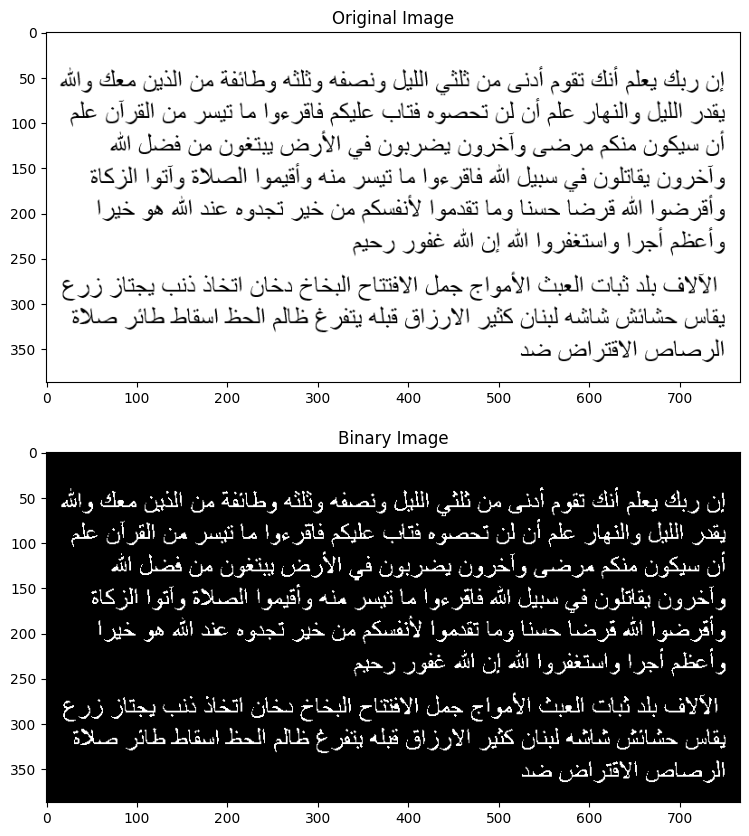

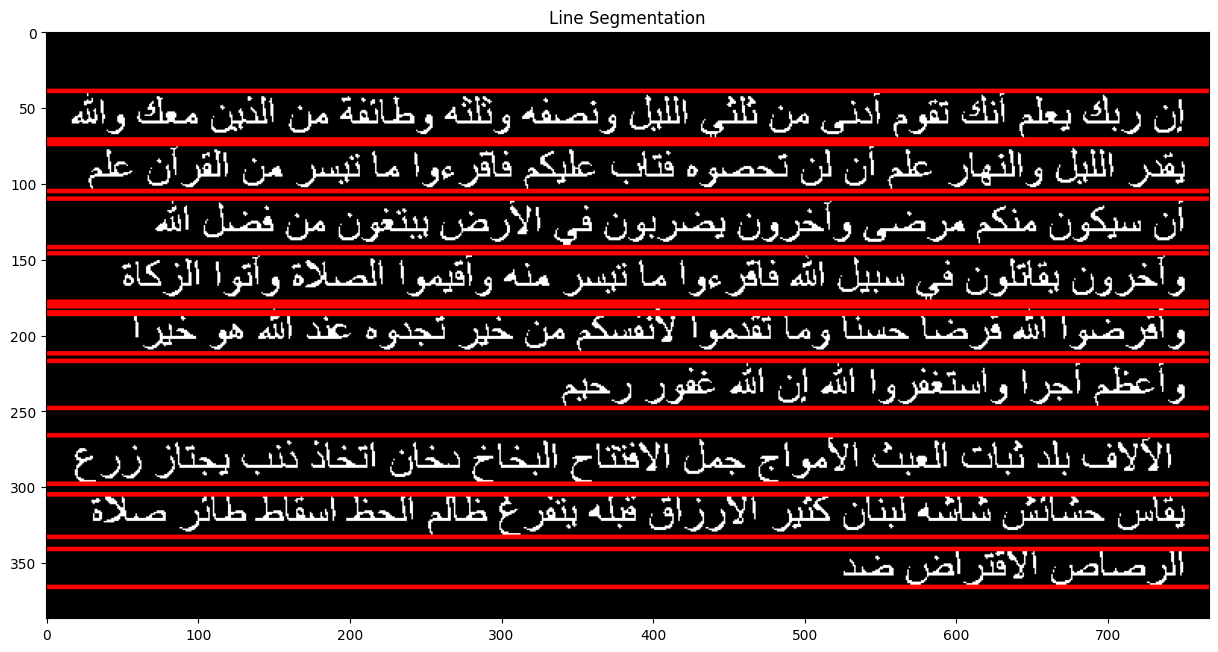

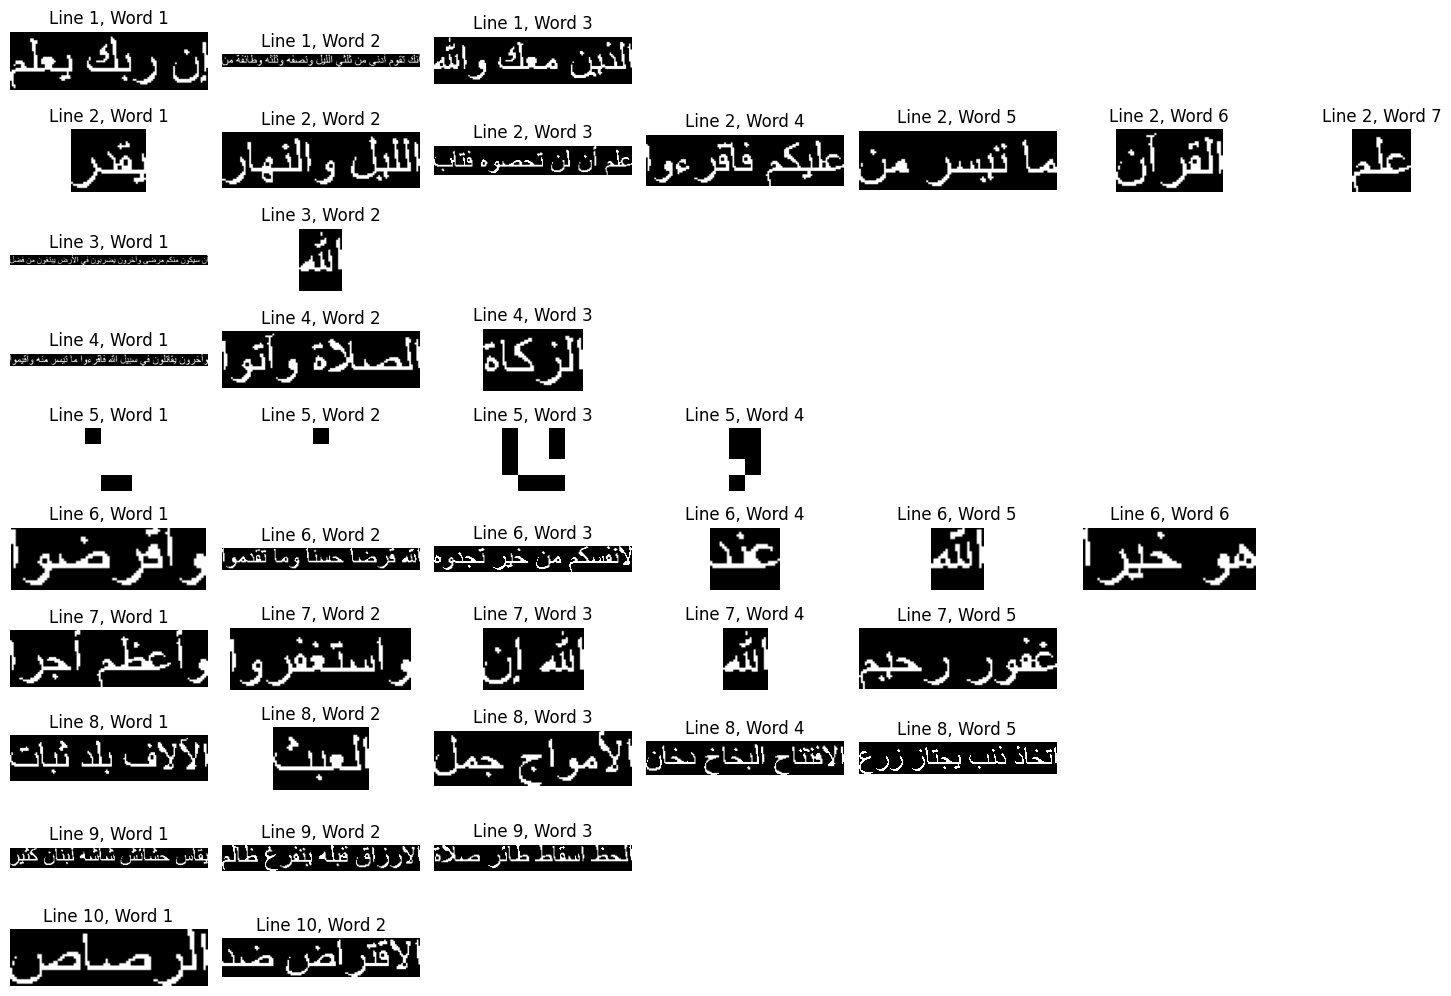

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def preprocess_image(image_path):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply thresholding to get binary image
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Remove noise
    kernel = np.ones((2, 2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    return img, binary

def segment_lines(binary_image):
    # Get horizontal projection profile
    h_proj = np.sum(binary_image, axis=1)
    
    # Find line boundaries
    line_boundaries = []
    in_line = False
    start = 0
    
    for i, count in enumerate(h_proj):
        if not in_line and count > 0:
            in_line = True
            start = i
        elif in_line and count == 0:
            in_line = False
            line_boundaries.append((start, i))
    
    # Handle case where the last line extends to the bottom of the image
    if in_line:
        line_boundaries.append((start, len(h_proj)))
    
    return line_boundaries

def segment_words(binary_image, line_boundaries):
    all_words = []
    
    for start_row, end_row in line_boundaries:
        # Extract the line
        line_image = binary_image[start_row:end_row, :]
        
        # Get vertical projection profile
        v_proj = np.sum(line_image, axis=0)
        
        # Find word boundaries
        word_boundaries = []
        in_word = False
        start = 0
        
        # For Arabic, we need a threshold to determine word spacing
        # This may need adjustment based on your specific images
        threshold = 5
        
        for i, count in enumerate(v_proj):
            if not in_word and count > threshold:
                in_word = True
                start = i
            elif in_word and count <= threshold:
                # Check if this is just a small gap within a word
                # Look ahead a few pixels to see if the text continues
                look_ahead = 10
                if i + look_ahead < len(v_proj) and max(v_proj[i:i+look_ahead]) > threshold:
                    continue
                
                in_word = False
                word_boundaries.append((start, i))
        
        # Handle case where the last word extends to the right edge
        if in_word:
            word_boundaries.append((start, len(v_proj)))
        
        # Extract word images
        words = []
        for start_col, end_col in word_boundaries:
            word_img = line_image[:, start_col:end_col]
            if word_img.size > 0:  # Ensure the word has content
                words.append(word_img)
        
        # In Arabic, words are read from right to left
        words.reverse()
        all_words.append(words)
    
    return all_words

def visualize_segmentation(original, binary, line_boundaries, all_words):
    # Visualize original and binary images
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    
    plt.subplot(2, 1, 2)
    plt.imshow(binary, cmap='gray')
    plt.title('Binary Image')
    
    # Draw line boundaries on binary image
    binary_with_lines = cv2.cvtColor(binary.copy(), cv2.COLOR_GRAY2BGR)
    for start_row, end_row in line_boundaries:
        cv2.line(binary_with_lines, (0, start_row), (binary.shape[1], start_row), (0, 0, 255), 2)
        cv2.line(binary_with_lines, (0, end_row), (binary.shape[1], end_row), (0, 0, 255), 2)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(binary_with_lines, cv2.COLOR_BGR2RGB))
    plt.title('Line Segmentation')
    
    # Display segmented words
    plt.figure(figsize=(15, 10))
    for i, line_words in enumerate(all_words):
        for j, word in enumerate(line_words):
            plt.subplot(len(all_words), max(len(line) for line in all_words), i*max(len(line) for line in all_words) + j + 1)
            plt.imshow(word, cmap='gray')
            plt.axis('off')
            plt.title(f'Line {i+1}, Word {j+1}')
    
    plt.tight_layout()
    plt.show()

def main(image_path):
    # Preprocess the image
    original, binary = preprocess_image(image_path)
    
    # Segment lines
    line_boundaries = segment_lines(binary)
    
    # Segment words
    all_words = segment_words(binary, line_boundaries)
    
    # Visualize results
    visualize_segmentation(original, binary, line_boundaries, all_words)
    
    return all_words

# Example usage
if __name__ == "__main__":
    image_path = "/kaggle/input/segmentationtest/test_20.jpg"
    segmented_words = main(image_path)

In [11]:
import cv2
import numpy as np

def segment_words(image_path, output_folder='words_output'):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Binarize using Otsu thresholding (works well for Arabic)
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Dilate to connect letters within the same word
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilated = cv2.dilate(binary, kernel, iterations=1)

    # Find contours (each should be a word)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours from right to left (Arabic direction)
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0], reverse=True)

    # Save segmented words
    import os
    os.makedirs(output_folder, exist_ok=True)
    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        word_img = image[y:y+h, x:x+w]
        cv2.imwrite(f"{output_folder}/word_{i}.png", word_img)

    print(f"Segmented {len(contours)} words and saved to {output_folder}")

# Example usage:
segment_words("/kaggle/input/segmentationtest/t1.PNG")


Segmented 30 words and saved to words_output
